# CNN for image classification (multi-classification)

References:
* https://medium.com/@golnaz.hosseini/beginner-tutorial-image-classification-using-pytorch-63f30dcc071c
* https://towardsdatascience.com/pytorch-image-classification-tutorial-for-beginners-94ea13f56f2

#### Dataset
* CIFAR10

### Convolutional layer
* **Kernel or filter** slides over the input image and computes the dot product of each pixel and filter based on the adjacent pixels.
* The kernel or filter is a learnable matrix that generates **feature maps**.
* These feature maps contain the extracted features from the input image, such as edges, shapes and textures.

### Pooling layer
* Performs **down-sampling** on the feature maps.
* Down-sampling involves partitioning the input image into smaller subregions, the **pooling regions or windows**, and replaces the values in each subregion with a single value, typically the maximum or average value within the subregion.
* Down-sampling reduces the size of feature maps, resulting in lower computational costs and preventing overfitting. 
* Types:
    * **Max pooling:**
    * **Average pooling:**

### Fully Connected layer
* Maps the input to a set of output values. Typically used as a classifier at the final layer.


In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 0
N_IMAGES_TO_DISPLAY = 10

In [3]:
!pip install torchsummary 

In [4]:
# deep learning libraries
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torchsummary
# standard libraries
import copy
import time
import os
import joblib
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

/home/dlopes/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset as train and test

In [5]:
def load_cifar10_dataset(transforms, 
                         train: bool, 
                         batch_size: int = BATCH_SIZE, 
                         num_workers: int = NUM_WORKERS):
    dataset = torchvision.datasets.CIFAR10(root="./data",
                                            train=train,
                                            transform=transforms,
                                            download=True
                                            )
    dataset_dl = DataLoader(dataset, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            num_workers=num_workers)
    classes = dataset.classes

    return dataset, dataset_dl, classes

In [6]:
image_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.RandomRotation(30),
                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        torchvision.transforms.RandomHorizontalFlip(),
                        torchvision.transforms.ColorJitter()
                    ])

In [7]:
train, train_dl, classes = load_cifar10_dataset(image_transforms, 
                                                True, 
                                                BATCH_SIZE, 
                                                NUM_WORKERS)
test, test_dl, _ = load_cifar10_dataset(image_transforms, 
                                        False, 
                                        BATCH_SIZE, 
                                        NUM_WORKERS)
dataloaders = {'train': train_dl, 'valid': test_dl, 'test': test_dl}
dataset = ConcatDataset([train, test])
print(len(classes))

Files already downloaded and verified
Files already downloaded and verified
10


In [8]:
def plot_single_image(image, label):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(label)
    plt.show()

In [9]:
def plot_images(n_images_to_display: int,
                dataset,
                classes):
    fig, ax = plt.subplots(1, n_images_to_display, figsize=(20, 10))

    for i in range(n_images_to_display):
        image, label = dataset[i]
        # If tensor, convert to numpy array
        image_to_show = image.numpy()
        if image_to_show.shape[0] == 3:  # For RGB images
            image_to_show = np.transpose(image, (1, 2, 0))
        elif image_to_show.shape[0] == 1:  # For grayscale images
            image_to_show = image.squeeze()
        ax[i].imshow(image_to_show)
        ax[i].set_title(f'{classes[label]}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

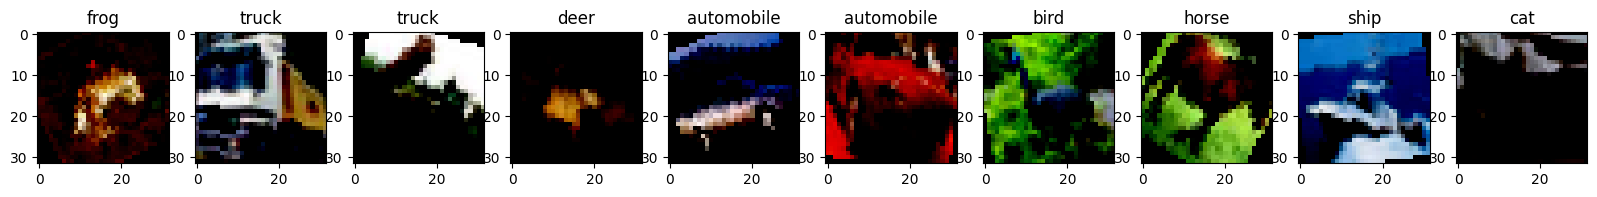

In [10]:
plot_images(N_IMAGES_TO_DISPLAY,
            train,
            classes)

In [11]:
labels = [label for _, label in dataset]
print(labels)

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8, 7, 1, 3, 0, 

<Axes: ylabel='count'>

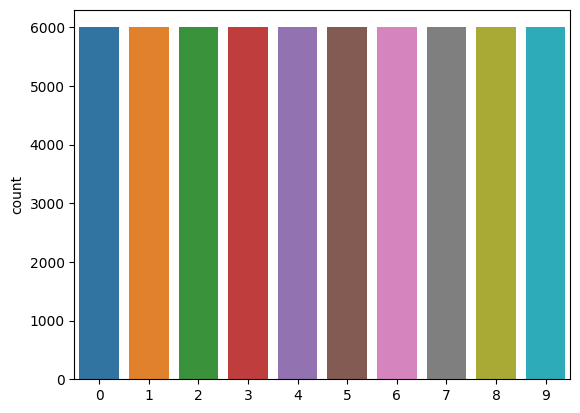

In [12]:
sns.countplot(x=labels)

### Define network architecture

In [13]:
class MultiClassImageClassificationCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassImageClassificationCNN, self).__init__()

        self.layer1 = self.conv_block(in_features=3, out_features=64)      # 16,16
        self.layer2 = self.conv_block(in_features=64, out_features=128)    # 8,8
        self.layer3 = self.conv_block(in_features=128, out_features=256)   # 4,4
        self.layer4 = self.conv_block(in_features=256, out_features=512)   # 2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes), # last fully connected layer should have same number of neurons as number of classes
                                        nn.Softmax())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def conv_block(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = MultiClassImageClassificationCNN(num_classes=len(classes)).to(device)
torchsummary.summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

/home/dlopes/anaconda3/envs/pytorch2/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Each conv_block has:
* a 2D convolutional layer
* a batch normalization layer
* ReLU activation function
* max pooling layer

The network has:
* 4 conv_blocks
* flatten layer: converts 2D feature maps into 1D, necessary for passing it to fully connected layers
* 3 linear fully connected layers used for classification intercalated by ReLU activation to introduce non-linearity
    * the last fully conencted layer has multiple neurons, which is suitable for **multi-class classification**
* the final layer is a **softmax** that normalized the output to a probability distribution over predicted output classes.
    * softmax in the final layer is suitable for **multi-class classification**

Input shape:
* 32 x 32 x n_channels, since the first layer is a convolutional layer, which typically doesn't change the spatial dimensions unless specified (through a stride greater than 1 or padding).

### Train network

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf') # choose a large number

    # Each epoch is a full pass over the training and testing data
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over baches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # nn.BCELoss requires labels to have same type has outputs
                    labels = labels.float()
                    # nn.BCELoss requires labels to have the same dimensions as outputs
                    if len(labels.shape) == 1 and len(outputs.shape) == 2:
                        loss = criterion(outputs, labels.unsqueeze(1))
                    else:
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    #print(f"outputs: {outputs}")
                    #print(f"preds: {preds}")
                    #print(f"labels: {labels}")

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
                # Store best stats 
                if epoch_acc > best_acc:
                    best_model_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc
                    best_loss = epoch_loss
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'Obtained best accuracy in epoch: {best_model_epoch}')
    print('Best test Acc: {:4f}'.format(best_acc))
    print('Best test Loss: {:4f}'.format(best_loss))

    history_dict = {'train_loss': train_loss_history, 'train_accuracy': train_acc_history,
                    'test_loss': test_loss_history, 'test_accuracy': test_acc_history}
    # ensure that we return the model with the best weights
    model.load_state_dict(best_model_wts)
    return model, history_dict

In [17]:
learning_rate = 0.001
num_epochs = 35
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), 
                           lr=learning_rate, 
                           momentum=momentum)
BASE_DIR = './models'
model_results_file = os.path.join(BASE_DIR, f'cifar10_cnn_model_{learning_rate}_{num_epochs}.pth')
history_dic_file = os.path.join(BASE_DIR, f'cifar10_cnn_history_dict_{learning_rate}_{num_epochs}.joblib')

In [41]:
if os.path.isfile(model_results_file) and os.path.isfile(history_dic_file):
    trained_model = torch.load(model_results_file)
    hist = joblib.load(history_dic_file)
else:
    trained_model, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs)
    torch.save(trained_model.state_dict(), model_results_file)
    joblib.dump(hist, history_dic_file)
print(trained_model)

OrderedDict([('layer1.0.weight', tensor([[[[-5.2100e-02, -5.7811e-02, -8.7795e-02],
          [-1.5817e-01, -1.3024e-01, -8.4937e-02],
          [ 1.7119e-01,  4.3220e-02,  8.9284e-02]],

         [[-1.0651e-01,  5.1473e-02,  1.4815e-01],
          [-1.0093e-01, -4.1232e-02, -1.0348e-01],
          [-1.1164e-01, -2.4454e-02, -1.8481e-01]],

         [[-9.3748e-02,  7.2999e-02, -3.6684e-02],
          [-2.0576e-01, -1.3038e-01, -1.3543e-01],
          [ 4.1900e-03, -2.0580e-02, -1.8142e-01]]],


        [[[ 1.7962e-01, -3.1584e-01,  2.8102e-01],
          [ 8.6982e-02, -3.2107e-01,  1.5260e-01],
          [ 3.4378e-02, -6.4691e-02, -3.2080e-02]],

         [[ 2.3464e-02, -3.5546e-01,  1.3587e-01],
          [ 3.0256e-01, -3.8253e-01,  2.0145e-01],
          [ 8.0027e-02,  3.1359e-02, -9.5098e-02]],

         [[ 4.7506e-02, -2.4222e-01,  2.5091e-01],
          [ 2.3225e-01, -2.7753e-01, -5.2498e-02],
          [-1.2591e-01,  8.2289e-02,  3.6606e-03]]],


        [[[ 2.6278e-01,  2.2136e-

### Learning curve and performance analysis

In [181]:
def plot_loss_accuracy(hist):
    plt.figure(figsize=(17,5))
    plt.subplot(121)
    plt.plot(hist['train_loss'],'-o')
    plt.plot(hist['test_loss'],'-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation loss')

    plt.subplot(122)
    plt.plot(hist['train_accuracy'],'-o')
    plt.plot(hist['test_accuracy'],'-o')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Accuracy')

    plt.ylim(0,1)
  
    plt.show()

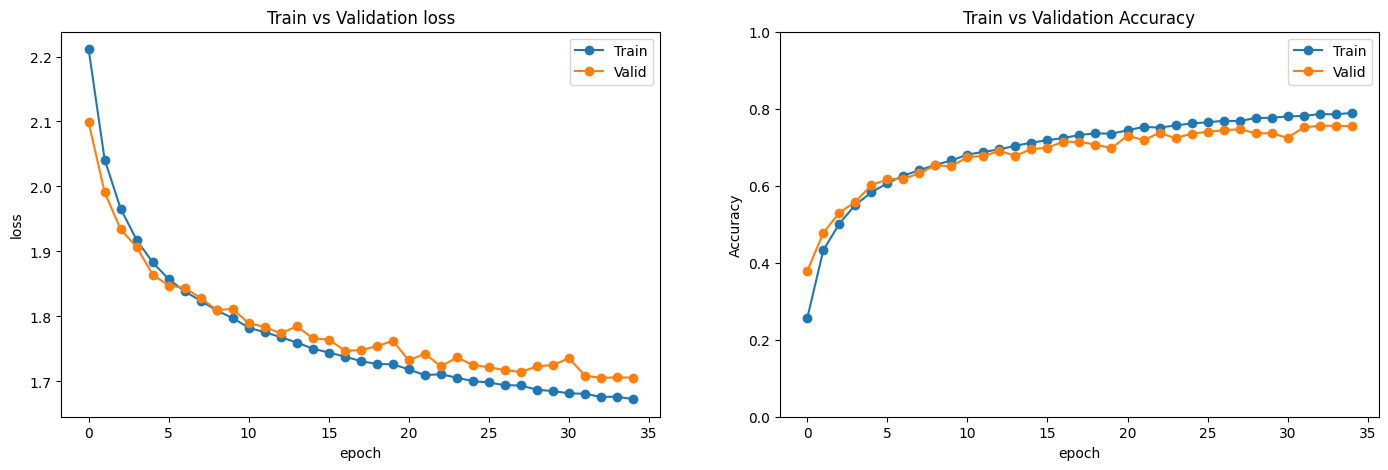

In [182]:
plot_loss_accuracy(hist)

Slight signs of **overfitting**, so we can apply a solution like **Regularization**.

Dataset: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification/code

I had to manually fix this dataset since several of the images were wrong.

### Try similar architecture for RGB Lions vs Cheetahs dataset (Binary classification)

In [21]:
!pip install albumentations

In [78]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
import albumentations as A
import albumentations.pytorch as AP
import albumentations.augmentations.geometric.transforms as AT
from albumentations.core.transforms_interface import ImageOnlyTransform
import shutil
import random

In [23]:
DATASET_BASE_DIR = './lions-or-cheetahs-image-classification/images/'
CHETAAHS_LIONS_IMAGE_SIZE = 32 # needs to have a spcific size for the model

In [158]:
class LionsCheetahsDataset(Dataset):
    def __init__(self, 
                 root_dir: str,
                 image_size: int,
                 batch_size: int,
                 df: pd.DataFrame, 
                 transform=None):
        self.root_dir = root_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.df = df
        self.transform = transform
        self.file_names = df['file_name'].values
        self.labels = df['label'].values

    # Get number of rows / samples
    def __len__(self):
        return len(self.df)
 
    # Get sample
    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        
        image = cv2.imread(file_path)
        if image is None:
            print(f"Error loading image: {file_path}")
            return None
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = Image.fromarray(image)
        # Apply augmentations
        if self.transform:     
            image = self.transform(image=image)['image']
    
        return (image, label)

In [164]:
def load_lions_cheetahs_dataset(transform,
                         image_size: int = CHETAAHS_LIONS_IMAGE_SIZE,
                         base_dir: str = DATASET_BASE_DIR, 
                         batch_size: int = BATCH_SIZE, 
                         num_workers: int = NUM_WORKERS):
    od.download("https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification/")
    
    sub_folders = ["Cheetahs", "Lions"]
    classes = [0, 1]
    data = []
    for s, l in zip(sub_folders, classes):
        for root, dir, files in os.walk(os.path.join(base_dir, s)):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    data.append((os.path.join(s,file), l))
    df = pd.DataFrame(data, columns=['file_name','label'])
    print(df)
    train_df, test_df = train_test_split(df, 
                                      test_size=0.2, 
                                      random_state=42)
    train_dataset = LionsCheetahsDataset(base_dir, 
                                         image_size,
                                         batch_size,
                                         train_df,
                                         transform=transform)
    train_dl = DataLoader(train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            num_workers=num_workers,
                            )
    test_dataset = LionsCheetahsDataset(base_dir, 
                                         image_size,
                                         batch_size,
                                         test_df,
                                         transform=transform)
    test_dl = DataLoader(test_dataset, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            num_workers=num_workers,
                        )

    return df, train_dataset, train_dl, test_dataset, test_dl, classes

In [119]:
# From torchvision to albumentations: 
# https://albumentations.ai/docs/examples/migrating_from_torchvision_to_albumentations/
cheetahs_lions_image_transforms = A.Compose([
                        A.Resize(CHETAAHS_LIONS_IMAGE_SIZE, CHETAAHS_LIONS_IMAGE_SIZE),
                        A.augmentations.geometric.rotate.Rotate(limit=30, p=0.5), # random rotate
                        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        A.HorizontalFlip(), # random horizontal flip
                        #A.ColorJitter(),
                        AP.transforms.ToTensorV2()
                    ])

In [120]:
(df_cheetahs_lions,
 train_cheetahs_lions, 
 train_cheetahs_lions_dl, 
 test_cheetahs_lions, 
 test_cheetahs_lions_dl, 
 classes_cheetahs_lions) = load_lions_cheetahs_dataset(cheetahs_lions_image_transforms, 
                                                    image_size=CHETAAHS_LIONS_IMAGE_SIZE,
                                                    base_dir=DATASET_BASE_DIR,
                                                    batch_size=BATCH_SIZE, 
                                                    num_workers=NUM_WORKERS
                                                    )
cheetahs_lions_dataloaders = {'train': train_cheetahs_lions_dl, 
                              'valid': test_cheetahs_lions_dl, 
                              'test': test_cheetahs_lions_dl}

Skipping, found downloaded files in "./lions-or-cheetahs-image-classification" (use force=True to force download)
                                         file_name  label
0                    Cheetahs/3054d68c25d49d54.jpg      0
1                    Cheetahs/b10d508caab7ce0b.jpg      0
2                    Cheetahs/c65aae5dd1d75984.jpg      0
3                              Cheetahs/cheeta.jpg      0
4    Cheetahs/pexels-frans-van-heerden-2017490.jpg      0
..                                             ...    ...
199                     Lions/9b91ad0cc4a42193.jpg      1
200                     Lions/027b71cacc5bf95e.jpg      1
201                             Lions/imagesa.jpeg      1
202                     Lions/03a0ceb0342e6ef9.jpg      1
203                             Lions/lion-cub.jpg      1

[204 rows x 2 columns]


<Axes: xlabel='label', ylabel='count'>

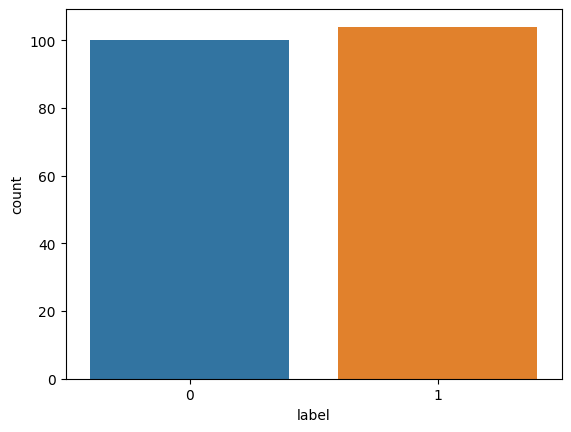

In [106]:
sns.countplot(data=df_cheetahs_lions, x='label')

[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]


<Axes: ylabel='count'>

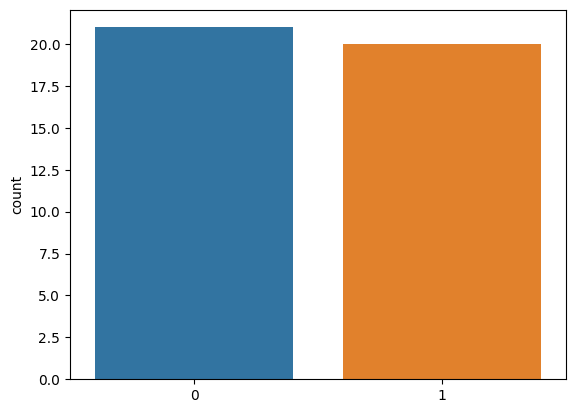

In [95]:
labels_test_cheetahs_lions = [label for _, label in test_cheetahs_lions]
print(labels_test_cheetahs_lions)
sns.countplot(x=labels_test_cheetahs_lions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

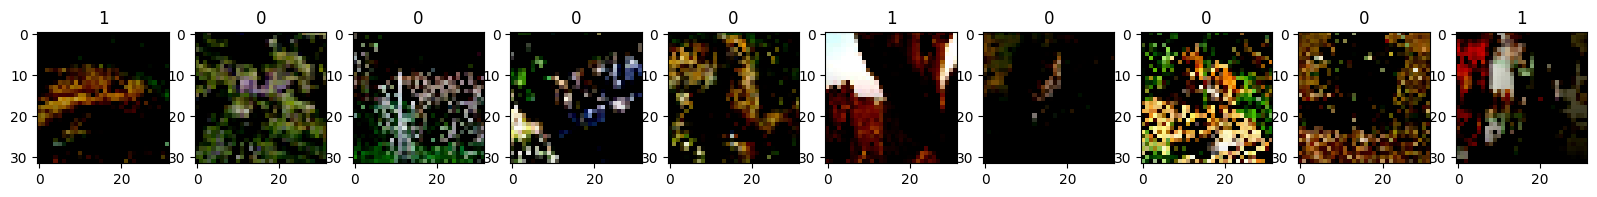

In [96]:
plot_images(N_IMAGES_TO_DISPLAY,
            train_cheetahs_lions,
            classes_cheetahs_lions)

In [107]:
class BinaryImageClassificationCNN(nn.Module):
    def __init__(self):
        super(BinaryImageClassificationCNN, self).__init__()

        self.layer1 = self.conv_block(in_features=3, out_features=64)      # 16,16
        self.layer2 = self.conv_block(in_features=64, out_features=128)    # 8,8
        self.layer3 = self.conv_block(in_features=128, out_features=256)   # 4,4
        self.layer4 = self.conv_block(in_features=256, out_features=512)   # 2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,1),
                                        nn.Sigmoid())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def conv_block(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

In [108]:
cheetahs_lions_model = BinaryImageClassificationCNN().to(device)
torchsummary.summary(cheetahs_lions_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

Each conv_block has:
* a 2D convolutional layer
* a batch normalization layer
* ReLU activation function
* max pooling layer

The network has:
* 4 conv_blocks
* flatten layer: converts 2D feature maps into 1D, necessary for passing it to fully connected layers
* 3 linear fully connected layers used for classification intercalated by ReLU activation to introduce non-linearity
    * the last fully connected layer has 1 neuron, which is suitable for **binary classification**
* the final layer is a **sigmoid** that outputs a probability between 0 and 1.
    * sigmoid in the final layer is suitable for **binary classification**

Input shape:
* 32 x 32 x n_channels, since the first layer is a convolutional layer, which typically doesn't change the spatial dimensions unless specified (through a stride greater than 1 or padding).

In [121]:
def train_model_binary(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf') # choose a large number

    # Each epoch is a full pass over the training and testing data
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over baches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.unsqueeze(1).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = outputs > 0.5  # Assuming sigmoid activation in the last layer

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #print(labels.data)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
                # Store best stats 
                if epoch_acc > best_acc:
                    best_model_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc
                    best_loss = epoch_loss
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'Obtained best accuracy in epoch: {best_model_epoch}')
    print('Best test Acc: {:4f}'.format(best_acc))
    print('Best test Loss: {:4f}'.format(best_loss))

    history_dict = {'train_loss': train_loss_history, 'train_accuracy': train_acc_history,
                    'test_loss': test_loss_history, 'test_accuracy': test_acc_history}
    # ensure that we return the model with the best weights
    model.load_state_dict(best_model_wts)
    return model, history_dict

In [122]:
cheetahs_lions_learning_rate = 0.01 # Using a different criterium may require a different learning rate
cheetahs_lions_num_epochs = 35
cheetahs_lions_num_momentum = 0.9
cheetahs_lions_criterion = nn.BCELoss() # Needs the sigmoid activation function at the end
#cheetahs_lions_criterion = nn.BCEWithLogitsLoss() # Sigmoid is included in the BCEWithLogitsLoss loss function
cheetahs_lions_optimizer = torch.optim.SGD(cheetahs_lions_model.parameters(), 
                                           lr=cheetahs_lions_learning_rate, 
                                           momentum=cheetahs_lions_num_momentum)
# cheetahs_lions_optimizer = torch.optim.Adam(cheetahs_lions_model.parameters(), 
#                                            lr=cheetahs_lions_learning_rate)
cheetahs_lions_model_results_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_model_{cheetahs_lions_learning_rate}_{cheetahs_lions_num_epochs}.pth')
cheetahs_lions_history_dic_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_history_dict_{cheetahs_lions_learning_rate}_{cheetahs_lions_num_epochs}.joblib')

In [123]:
if os.path.isfile(cheetahs_lions_model_results_file) \
        and os.path.isfile(cheetahs_lions_history_dic_file):
    cheetahs_lions_trained_model = torch.load(cheetahs_lions_model_results_file)
    cheetahs_lions_hist = joblib.load(cheetahs_lions_history_dic_file)
else:
    (cheetahs_lions_trained_model, 
     cheetahs_lions_hist) = train_model_binary(cheetahs_lions_model, 
                                                cheetahs_lions_dataloaders, 
                                                cheetahs_lions_criterion, 
                                                cheetahs_lions_optimizer, 
                                                cheetahs_lions_num_epochs)
    torch.save(cheetahs_lions_trained_model.state_dict(), 
               cheetahs_lions_model_results_file)
    joblib.dump(cheetahs_lions_hist, cheetahs_lions_history_dic_file)
#print(cheetahs_lions_trained_model)

Epoch 1/35
train Loss: 0.6180, Acc: 0.6933
test Loss: 0.8603, Acc: 0.4878

Epoch 2/35
train Loss: 0.6211, Acc: 0.6748
test Loss: 0.7233, Acc: 0.4878

Epoch 3/35
train Loss: 0.5446, Acc: 0.7055
test Loss: 0.8492, Acc: 0.4878

Epoch 4/35
train Loss: 0.5540, Acc: 0.7239
test Loss: 0.6863, Acc: 0.6098

Epoch 5/35
train Loss: 0.5686, Acc: 0.6687
test Loss: 0.9144, Acc: 0.5366

Epoch 6/35
train Loss: 0.6089, Acc: 0.6810
test Loss: 0.7473, Acc: 0.6341

Epoch 7/35
train Loss: 0.5404, Acc: 0.7178
test Loss: 0.7003, Acc: 0.5366

Epoch 8/35
train Loss: 0.5491, Acc: 0.7055
test Loss: 0.6953, Acc: 0.6341

Epoch 9/35
train Loss: 0.5022, Acc: 0.7362
test Loss: 0.8309, Acc: 0.5366

Epoch 10/35
train Loss: 0.4804, Acc: 0.7853
test Loss: 0.7316, Acc: 0.6341

Epoch 11/35
train Loss: 0.5528, Acc: 0.7239
test Loss: 1.0657, Acc: 0.5122

Epoch 12/35
train Loss: 0.4928, Acc: 0.7423
test Loss: 0.6732, Acc: 0.6585

Epoch 13/35
train Loss: 0.4404, Acc: 0.8098
test Loss: 0.7571, Acc: 0.6098

Epoch 14/35
train Los

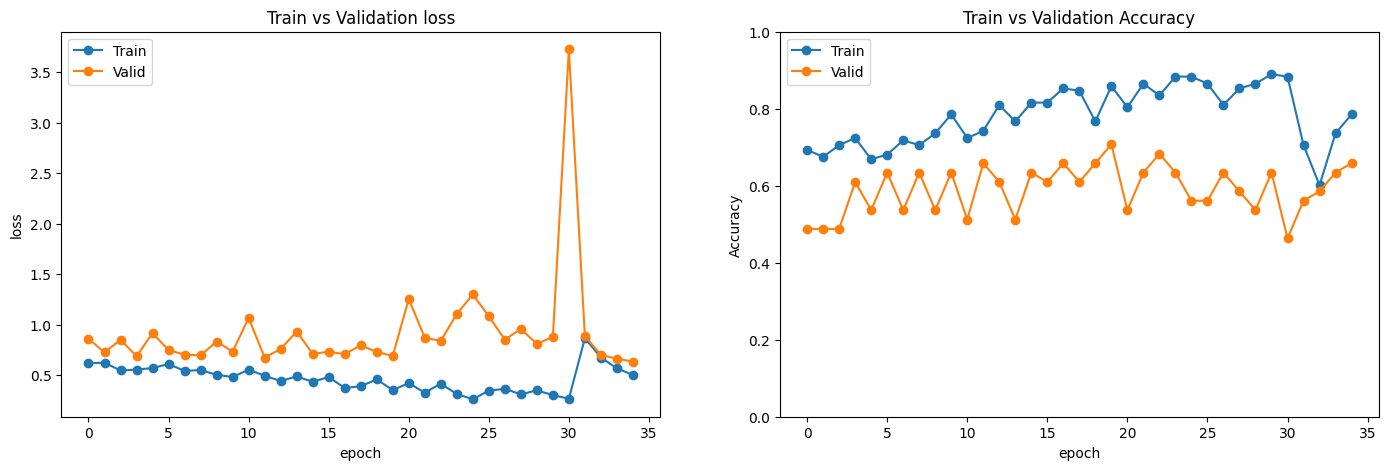

In [183]:
plot_loss_accuracy(cheetahs_lions_hist)

This is the typical **zig-zag learning curve**, which generally means that our dataset has some problems. Due to the small number of samples in the dataset, I 'll assume that this is the problem and perform data augmentation to generate more samples.

#### Add more samples to the cheetahs linons dataset using more transforms for data augmentation

In [165]:
N_AUGMENTED_SAMPLES_PER_IMAGE = 5
TARGET_DATASET_FOLDER = "./lions-or-cheetahs-image-classification-augmented/"

In [148]:
if not os.path.isdir(TARGET_DATASET_FOLDER):
    os.mkdir(TARGET_DATASET_FOLDER)

In [149]:
class RandomDynamicCenterCrop(ImageOnlyTransform):
    """
        Create custom center crop transformation to crop percentage of 
        the image total size instead of a fixed value. This percentage
        will be randomly selected between min_pct and max_pct.
    """
    def __init__(self, min_pct, max_pct, always_apply=False, p=1.0):
        super(RandomDynamicCenterCrop, self).__init__(always_apply, p)
        self.min_pct = min_pct
        self.max_pct = max_pct

    def apply(self, img, **params):
        height, width = img.shape[:2]
        # Randomly select a percentage between min_pct and max_pct
        crop_pct = random.uniform(self.min_pct, self.max_pct)
        crop_height = int(height * crop_pct)
        crop_width = int(width * crop_pct)
        return A.CenterCrop(height=crop_height, width=crop_width)(image=img)['image']

In [150]:
generate_more_samples_cheetah_lions_transforms = A.Compose([
                        A.OneOf([
                          A.HorizontalFlip(p=1),
                          A.RandomRotate90(p=1),
                          A.VerticalFlip(p=1),
                          RandomDynamicCenterCrop(min_pct=0.5, max_pct=0.95),
                          #A.CenterCrop(width=128, height=128),
                          A.GridDropout(holes_number_x=3, holes_number_y=3, random_offset=True, unit_size_min=2, unit_size_max=20)         
                        ], p=1),
                        A.OneOf([
                          A.MotionBlur(p=1),
                          A.OpticalDistortion(p=1),
                          A.GaussNoise(p=1) 
                        ]),
                        # Light transforms
                        A.RandomBrightnessContrast(),    
                        A.RandomGamma(p=1),
                        # Geometric transforms
                        AT.ShiftScaleRotate()
])

In [151]:
def save_augmented_images(transform,
                          data_folder=DATASET_BASE_DIR, 
                          target_data_folder=TARGET_DATASET_FOLDER,
                          num_augmented_images=N_AUGMENTED_SAMPLES_PER_IMAGE):
    sub_folders = ["Cheetahs", "Lions"]
    for s in sub_folders:
        source_sub_folder = os.path.join(data_folder, s)
        target_sub_folder = os.path.join(target_data_folder, s)
        if not os.path.isdir(target_sub_folder):
            os.mkdir(target_sub_folder)
        for subdir, dirs, files in os.walk(source_sub_folder):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    file_path = os.path.join(source_sub_folder, file)
                    image = cv2.imread(file_path)
                    # Because, by default, cv2.imread reads images in BGR format
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Copy original image
                    shutil.copy2(file_path, os.path.join(target_sub_folder, file))
                    # Generate more images by applying tranformations
                    for i in range(num_augmented_images):
                        augmented_image = transform(image=image)['image']
                        new_file_path = os.path.join(target_sub_folder, f"{file.split('.jp')[0]}_aug_{i}.jpg")
                        cv2.imwrite(new_file_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

In [152]:
save_augmented_images(generate_more_samples_cheetah_lions_transforms,
                      DATASET_BASE_DIR, 
                      TARGET_DATASET_FOLDER,
                      N_AUGMENTED_SAMPLES_PER_IMAGE)

### Retry with bigger dataset with augmented samples

In [167]:
(df_cheetahs_lions_augmented,
 train_cheetahs_lions_augmented, 
 train_cheetahs_lions_augmented_dl, 
 test_cheetahs_lions_augmented, 
 test_cheetahs_lions_augmented_dl, 
 _) = load_lions_cheetahs_dataset(cheetahs_lions_image_transforms, 
                                                    image_size=CHETAAHS_LIONS_IMAGE_SIZE,
                                                    base_dir=TARGET_DATASET_FOLDER,
                                                    batch_size=BATCH_SIZE, 
                                                    num_workers=NUM_WORKERS
                                                    )
cheetahs_lions_augmented_dataloaders = {'train': train_cheetahs_lions_augmented_dl, 
                              'valid': test_cheetahs_lions_augmented_dl, 
                              'test': test_cheetahs_lions_augmented_dl}

Skipping, found downloaded files in "./lions-or-cheetahs-image-classification" (use force=True to force download)
                                           file_name  label
0                Cheetahs/150bf6ac5d17ed58_aug_3.jpg      0
1                      Cheetahs/3054d68c25d49d54.jpg      0
2                Cheetahs/00bb45a8568a3474_aug_4.jpg      0
3                Cheetahs/13cec8f6c995afba_aug_3.jpg      0
4                Cheetahs/07642e275bb2b869_aug_0.jpg      0
...                                              ...    ...
1219                      Lions/03a0ceb0342e6ef9.jpg      1
1220                              Lions/lion-cub.jpg      1
1221  Lions/istockphoto-1131118951-612x612_aug_0.jpg      1
1222                     Lions/images (21)_aug_1.jpg      1
1223                 Lions/FjR6NTIWAAYRNew_aug_1.jpg      1

[1224 rows x 2 columns]


<Axes: xlabel='label', ylabel='count'>

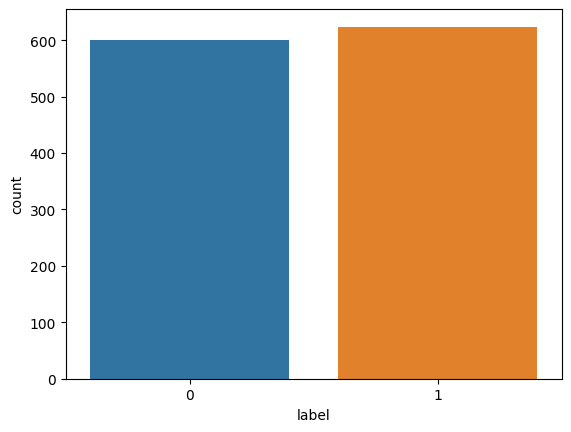

In [168]:
sns.countplot(data=df_cheetahs_lions_augmented, x='label')

We have way more samples this time, let's see if it solves the zig-zag learning curve problem.

In [169]:
cheetahs_lions_augmented_model = BinaryImageClassificationCNN().to(device)

In [170]:
cheetahs_lions_augmented_learning_rate = 0.01 # Using a different criterium may require a different learning rate
cheetahs_lions_augmented_num_epochs = 35
cheetahs_lions_augmented_num_momentum = 0.9
cheetahs_lions_augmented_criterion = nn.BCELoss() # Needs the sigmoid activation function at the end
#cheetahs_lions_criterion = nn.BCEWithLogitsLoss() # Sigmoid is included in the BCEWithLogitsLoss loss function
cheetahs_lions_augmented_optimizer = torch.optim.SGD(cheetahs_lions_augmented_model.parameters(), 
                                           lr=cheetahs_lions_augmented_learning_rate, 
                                           momentum=cheetahs_lions_augmented_num_momentum)
# cheetahs_lions_optimizer = torch.optim.Adam(cheetahs_lions_model.parameters(), 
#                                            lr=cheetahs_lions_learning_rate)
cheetahs_lions_augmented_model_results_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_model_{cheetahs_lions_augmented_learning_rate}_{cheetahs_lions_augmented_num_epochs}_augmented.pth')
cheetahs_lions_augmented_history_dic_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_history_dict_{cheetahs_lions_augmented_learning_rate}_{cheetahs_lions_augmented_num_epochs}_augmented.joblib')

In [171]:
if os.path.isfile(cheetahs_lions_augmented_model_results_file) \
        and os.path.isfile(cheetahs_lions_augmented_history_dic_file):
    cheetahs_lions_augmented_trained_model = torch.load(cheetahs_lions_augmented_model_results_file)
    cheetahs_lions_augmented_hist = joblib.load(cheetahs_lions_augmented_history_dic_file)
else:
    (cheetahs_lions_augmented_trained_model, 
     cheetahs_lions_augmented_hist) = train_model_binary(cheetahs_lions_augmented_model, 
                                                cheetahs_lions_augmented_dataloaders, 
                                                cheetahs_lions_augmented_criterion, 
                                                cheetahs_lions_augmented_optimizer, 
                                                cheetahs_lions_augmented_num_epochs)
    torch.save(cheetahs_lions_augmented_trained_model.state_dict(), 
               cheetahs_lions_augmented_model_results_file)
    joblib.dump(cheetahs_lions_augmented_hist, cheetahs_lions_augmented_history_dic_file)

Epoch 1/35
train Loss: 0.6357, Acc: 0.6404
test Loss: 0.7541, Acc: 0.5306

Epoch 2/35
train Loss: 0.5688, Acc: 0.7150
test Loss: 0.5036, Acc: 0.7796

Epoch 3/35
train Loss: 0.5319, Acc: 0.7263
test Loss: 0.6187, Acc: 0.6735

Epoch 4/35
train Loss: 0.5414, Acc: 0.7303
test Loss: 0.9178, Acc: 0.6449

Epoch 5/35
train Loss: 0.5012, Acc: 0.7549
test Loss: 0.6037, Acc: 0.6653

Epoch 6/35
train Loss: 0.5026, Acc: 0.7630
test Loss: 0.6519, Acc: 0.6857

Epoch 7/35
train Loss: 0.5121, Acc: 0.7344
test Loss: 0.5150, Acc: 0.7306

Epoch 8/35
train Loss: 0.4338, Acc: 0.8018
test Loss: 0.6266, Acc: 0.7306

Epoch 9/35
train Loss: 0.4027, Acc: 0.8325
test Loss: 0.4935, Acc: 0.7714

Epoch 10/35
train Loss: 0.3563, Acc: 0.8509
test Loss: 0.7186, Acc: 0.6857

Epoch 11/35
train Loss: 0.3842, Acc: 0.8386
test Loss: 0.5090, Acc: 0.7551

Epoch 12/35
train Loss: 0.3394, Acc: 0.8570
test Loss: 0.5160, Acc: 0.7878

Epoch 13/35
train Loss: 0.2817, Acc: 0.8744
test Loss: 0.4623, Acc: 0.7918

Epoch 14/35
train Los

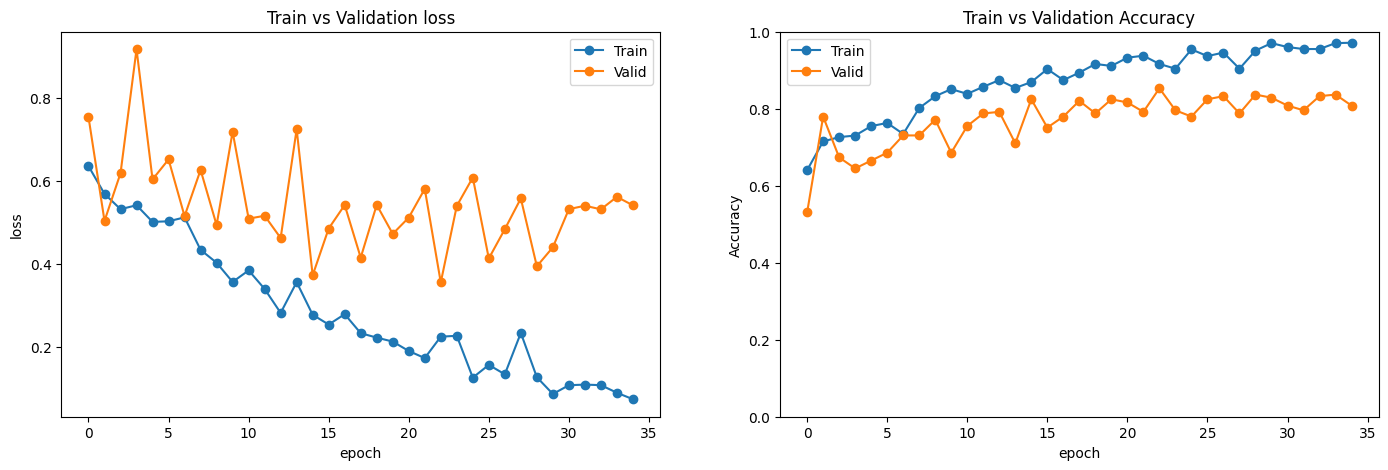

In [184]:
plot_loss_accuracy(cheetahs_lions_augmented_hist)

Is still overfitting, but got much better with adding more samples through data augmentation.

### Add regularization to reduce overfitting

#### Add dropout layers between the last hidden layers

In [173]:
class BinaryImageClassificationDropoutCNN(nn.Module):
    def __init__(self):
        super(BinaryImageClassificationDropoutCNN, self).__init__()

        self.layer1 = self.conv_block(in_features=3, out_features=64)      # 16,16
        self.layer2 = self.conv_block(in_features=64, out_features=128)    # 8,8
        self.layer3 = self.conv_block(in_features=128, out_features=256)   # 4,4
        self.layer4 = self.conv_block(in_features=256, out_features=512)   # 2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(512,1),
                                        nn.Sigmoid())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def conv_block(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

In [174]:
cheetahs_lions_augmented_dropout_model = BinaryImageClassificationDropoutCNN().to(device)

In [175]:
cheetahs_lions_augmented_dropout_learning_rate = 0.01 # Using a different criterium may require a different learning rate
cheetahs_lions_augmented_dropout_num_epochs = 35
cheetahs_lions_augmented_dropout_num_momentum = 0.9
cheetahs_lions_augmented_dropout_criterion = nn.BCELoss() # Needs the sigmoid activation function at the end
cheetahs_lions_augmented_dropout_optimizer = torch.optim.SGD(cheetahs_lions_augmented_dropout_model.parameters(), 
                                           lr=cheetahs_lions_augmented_dropout_learning_rate, 
                                           momentum=cheetahs_lions_augmented_dropout_num_momentum)
cheetahs_lions_augmented_dropout_model_results_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_model_{cheetahs_lions_augmented_dropout_learning_rate}_{cheetahs_lions_augmented_dropout_num_epochs}_augmented_dropout.pth')
cheetahs_lions_augmented_dropout_history_dic_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_history_dict_{cheetahs_lions_augmented_dropout_learning_rate}_{cheetahs_lions_augmented_dropout_num_epochs}_augmented_dropout.joblib')

In [176]:
if os.path.isfile(cheetahs_lions_augmented_dropout_model_results_file) \
        and os.path.isfile(cheetahs_lions_augmented_dropout_history_dic_file):
    cheetahs_lions_augmented_dropout_trained_model = torch.load(cheetahs_lions_augmented_dropout_model_results_file)
    cheetahs_lions_augmented_dropout_hist = joblib.load(cheetahs_lions_augmented_dropout_history_dic_file)
else:
    (cheetahs_lions_augmented_dropout_trained_model, 
     cheetahs_lions_augmented_dropout_hist) = train_model_binary(cheetahs_lions_augmented_dropout_model, 
                                                cheetahs_lions_augmented_dataloaders, 
                                                cheetahs_lions_augmented_dropout_criterion, 
                                                cheetahs_lions_augmented_dropout_optimizer, 
                                                cheetahs_lions_augmented_dropout_num_epochs)
    torch.save(cheetahs_lions_augmented_dropout_trained_model.state_dict(), 
               cheetahs_lions_augmented_dropout_model_results_file)
    joblib.dump(cheetahs_lions_augmented_dropout_hist, cheetahs_lions_augmented_dropout_history_dic_file)

Epoch 1/35
train Loss: 0.6807, Acc: 0.5781
test Loss: 0.6823, Acc: 0.5306

Epoch 2/35
train Loss: 0.6049, Acc: 0.6834
test Loss: 0.6055, Acc: 0.6776

Epoch 3/35
train Loss: 0.5833, Acc: 0.7017
test Loss: 0.6152, Acc: 0.6857

Epoch 4/35
train Loss: 0.5678, Acc: 0.7120
test Loss: 0.6592, Acc: 0.6367

Epoch 5/35
train Loss: 0.5665, Acc: 0.7181
test Loss: 0.6367, Acc: 0.6612

Epoch 6/35
train Loss: 0.5733, Acc: 0.7058
test Loss: 0.5592, Acc: 0.7061

Epoch 7/35
train Loss: 0.5140, Acc: 0.7446
test Loss: 0.5026, Acc: 0.7306

Epoch 8/35
train Loss: 0.4711, Acc: 0.7896
test Loss: 0.6034, Acc: 0.7347

Epoch 9/35
train Loss: 0.4740, Acc: 0.7814
test Loss: 0.5204, Acc: 0.7429

Epoch 10/35
train Loss: 0.4856, Acc: 0.7712
test Loss: 0.6376, Acc: 0.7102

Epoch 11/35
train Loss: 0.4146, Acc: 0.8141
test Loss: 0.5079, Acc: 0.7388

Epoch 12/35
train Loss: 0.4047, Acc: 0.8315
test Loss: 0.4680, Acc: 0.7714

Epoch 13/35
train Loss: 0.4344, Acc: 0.7906
test Loss: 0.5520, Acc: 0.6939

Epoch 14/35
train Los

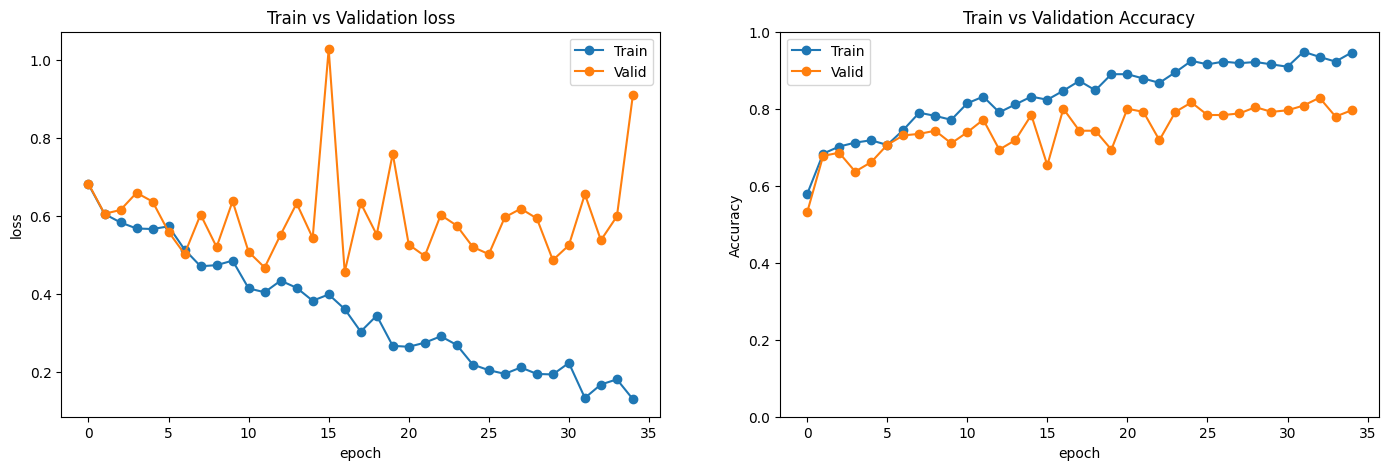

In [185]:
plot_loss_accuracy(cheetahs_lions_augmented_dropout_hist)

Adding dropout between the last hidden layers helps significantly reduce the overfitting and improve the validation accuracy, but overfitting is still happening.

#### Add L2 Regularization

In [195]:
class BinaryImageClassificationL2RegularizationCNN(nn.Module):
    def __init__(self):
        super(BinaryImageClassificationL2RegularizationCNN, self).__init__()

        self.layer1 = self.conv_block(in_features=3, out_features=64)      # 16,16
        
        # https://saturncloud.io/blog/how-to-initialize-weights-in-pytorch-a-guide-for-data-scientists/
        # Xavier initilization to initialize weights
        # Samples weights from a normal distribution with a mean of 0 and variation of 1/n
        # Good to avoid vainishing or exploding gradients
        # Xavier initialization is good for sigmoid and tanh activation functions
        # nn.init.xavier_normal_(self.layer1.weight)
        # nn.init.zeros_(self.layer1.bias)

        # He initialization to initialize weights
        # Samples weights from a normal distribution with a mean of 0 and variation of 2/n
        # Good to avoid vainishing or exploding gradients
        # He initialization is good for ReLU activation functions
        nn.init.kaiming_normal_(self.layer1[0].weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.layer1[0].bias)

        self.layer2 = self.conv_block(in_features=64, out_features=128)    # 8,8
        self.layer3 = self.conv_block(in_features=128, out_features=256)   # 4,4
        self.layer4 = self.conv_block(in_features=256, out_features=512)   # 2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,1),
                                        nn.Sigmoid())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def conv_block(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

# TODO: ADDING WEIGHT INITIALIZATION DIDN'T CHANGE ANYTHING, I THINK I HAVE A PROBLEM CALCULATING THE LOSS AND THE ACCURACY WITH THE NEW OPTIMIZER

In [196]:
cheetahs_lions_augmented_l2_reg_model = BinaryImageClassificationL2RegularizationCNN().to(device)

In [197]:
cheetahs_lions_augmented_l2_reg_learning_rate = 0.01 # Using a different criterium may require a different learning rate
cheetahs_lions_augmented_l2_reg_num_epochs = 35
cheetahs_lions_augmented_l2_reg_criterion = nn.BCELoss() # Needs the sigmoid activation function at the end
cheetahs_lions_augmented_l2_reg_optimizer = torch.optim.Adam(cheetahs_lions_augmented_l2_reg_model.parameters(), 
                                           lr=cheetahs_lions_augmented_l2_reg_learning_rate, 
                                           weight_decay=1e-8) # L2 Regularization
cheetahs_lions_augmented_l2_reg_model_results_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_model_{cheetahs_lions_augmented_l2_reg_learning_rate}_{cheetahs_lions_augmented_l2_reg_num_epochs}_augmented_l2_reg.pth')
cheetahs_lions_augmented_l2_reg_history_dic_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_history_dict_{cheetahs_lions_augmented_l2_reg_learning_rate}_{cheetahs_lions_augmented_l2_reg_num_epochs}_augmented_l2_reg.joblib')

In [199]:
if os.path.isfile(cheetahs_lions_augmented_l2_reg_model_results_file) \
        and os.path.isfile(cheetahs_lions_augmented_l2_reg_history_dic_file):
    cheetahs_lions_augmented_l2_reg_trained_model = torch.load(cheetahs_lions_augmented_l2_reg_model_results_file)
    cheetahs_lions_augmented_l2_reg_hist = joblib.load(cheetahs_lions_augmented_l2_reg_history_dic_file)
else:
    (cheetahs_lions_augmented_l2_reg_trained_model, 
     cheetahs_lions_augmented_l2_reg_hist) = train_model_binary(cheetahs_lions_augmented_l2_reg_model, 
                                                cheetahs_lions_augmented_dataloaders, 
                                                cheetahs_lions_augmented_l2_reg_criterion, 
                                                cheetahs_lions_augmented_l2_reg_optimizer, 
                                                cheetahs_lions_augmented_l2_reg_num_epochs)
    torch.save(cheetahs_lions_augmented_l2_reg_trained_model.state_dict(), 
               cheetahs_lions_augmented_l2_reg_model_results_file)
    joblib.dump(cheetahs_lions_augmented_l2_reg_hist, cheetahs_lions_augmented_l2_reg_history_dic_file)

Epoch 1/35
train Loss: 50.2780, Acc: 0.4801
test Loss: 48.5714, Acc: 0.5143

Epoch 2/35
train Loss: 51.5832, Acc: 0.4842
test Loss: 48.5714, Acc: 0.5143

Epoch 3/35
train Loss: 51.5832, Acc: 0.4842
test Loss: 48.5714, Acc: 0.5143

Epoch 4/35
train Loss: 51.5832, Acc: 0.4842
test Loss: 48.5714, Acc: 0.5143

Epoch 5/35
train Loss: 51.5832, Acc: 0.4842


KeyboardInterrupt: 

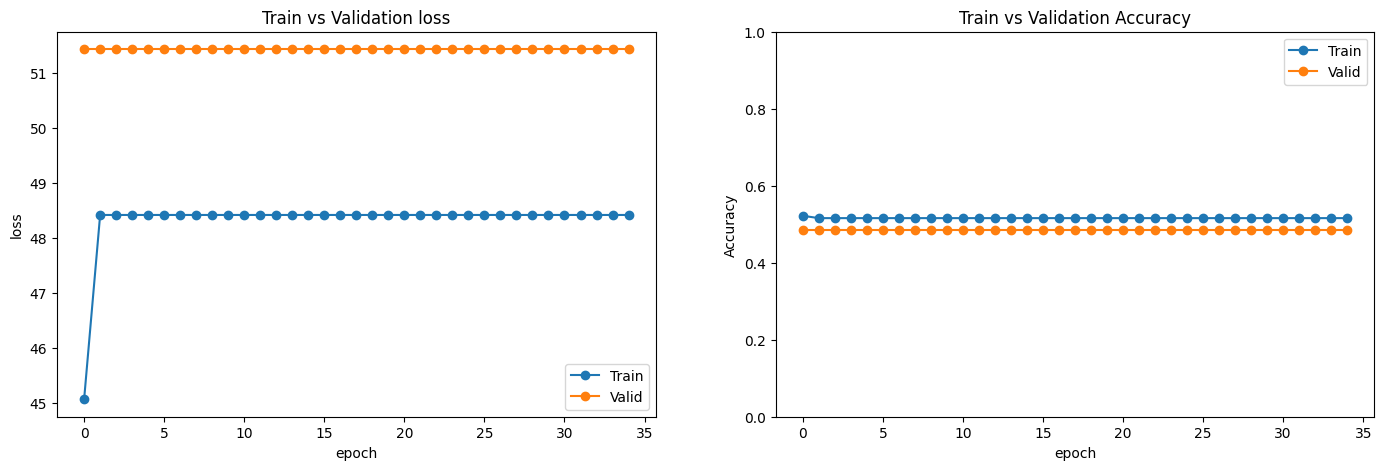

In [186]:
plot_loss_accuracy(cheetahs_lions_augmented_l2_reg_hist)

#TODO: FIX THIS!!

#### Adding L1 Regularization

# TODO: FINISH THIS CODE

### Try alternative CNN architecture

References:
* https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9

In [187]:
class BinaryImageClassificationAlternativeCNN(nn.Module):
    def __init__(self):
        super(BinaryImageClassificationAlternativeCNN, self).__init__()

        self.layer1 = self.conv_block(in_features=3, 
                                      out_features=64,
                                      dropout=0.1, 
                                      kernel_size=5, 
                                      stride=1, 
                                      padding=2)      
        self.layer2 = self.conv_block(in_features=64, 
                                      out_features=128,
                                      dropout=0.1, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1)    
        self.layer3 = self.conv_block(in_features=128, 
                                      out_features=256,
                                      dropout=0.1, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding=1)

        self.classifier = nn.Sequential(nn.Conv2d(in_channels=64, 
                                                  out_channels=2, 
                                                  kernel_size=56, 
                                                  stride=1, 
                                                  padding=0),
                                        nn.MaxPool2d(kernel_size=2, stride=2)
                                       )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)
        return x
    
    def conv_block(self, in_features, out_features, dropout, **kwargs):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, 
                                       out_channels=out_features, 
                                       **kwargs),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.Dropout2d(p=dropout)
                            )

In [188]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_tag, dim=1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

def train_model_binary_alt(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf') # choose a large number

    # Each epoch is a full pass over the training and testing data
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over baches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.unsqueeze(1).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #print(labels.data)
                running_corrects += torch.sum(outputs == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = binary_acc(outputs, labels)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
                # Store best stats 
                if epoch_acc > best_acc:
                    best_model_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc
                    best_loss = epoch_loss
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'Obtained best accuracy in epoch: {best_model_epoch}')
    print('Best test Acc: {:4f}'.format(best_acc))
    print('Best test Loss: {:4f}'.format(best_loss))

    history_dict = {'train_loss': train_loss_history, 'train_accuracy': train_acc_history,
                    'test_loss': test_loss_history, 'test_accuracy': test_acc_history}
    # ensure that we return the model with the best weights
    model.load_state_dict(best_model_wts)
    return model, history_dict

In [192]:
cheetahs_lions_augmented_alt_model = BinaryImageClassificationAlternativeCNN().to(device)
torchsummary.summary(cheetahs_lions_augmented_alt_model, (3,32,32))

RuntimeError: Given groups=1, weight of size [2, 64, 56, 56], expected input[2, 256, 32, 32] to have 64 channels, but got 256 channels instead

In [190]:
cheetahs_lions_augmented_alt_learning_rate = 0.01 # Using a different criterium may require a different learning rate
cheetahs_lions_augmented_alt_num_epochs = 35
# We don't need to apply log_softmax in the last layer for training, but we need to apply it for validation and testing
cheetahs_lions_augmented_alt_criterion = nn.CrossEntropyLoss() # Intead of returning a single output of 0 or 1, it will return two values between 0 and 1 (the probabilities of the output being 0 or 1)
cheetahs_lions_augmented_alt_optimizer = torch.optim.Adam(cheetahs_lions_augmented_alt_model.parameters(), 
                                           lr=cheetahs_lions_augmented_alt_learning_rate)
cheetahs_lions_augmented_alt_model_results_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_model_{cheetahs_lions_augmented_alt_learning_rate}_{cheetahs_lions_augmented_alt_num_epochs}_augmented_alt.pth')
cheetahs_lions_augmented_alt_history_dic_file = os.path.join(BASE_DIR, f'cheetahs_lions_cnn_history_dict_{cheetahs_lions_augmented_alt_learning_rate}_{cheetahs_lions_augmented_alt_num_epochs}_augmented_alt.joblib')

In [191]:
if os.path.isfile(cheetahs_lions_augmented_alt_model_results_file) \
        and os.path.isfile(cheetahs_lions_augmented_alt_history_dic_file):
    cheetahs_lions_augmented_alt_trained_model = torch.load(cheetahs_lions_augmented_alt_model_results_file)
    cheetahs_lions_augmented_alt_hist = joblib.load(cheetahs_lions_augmented_alt_history_dic_file)
else:
    (cheetahs_lions_augmented_alt_trained_model, 
     cheetahs_lions_augmented_alt_hist) = train_model_binary_alt(cheetahs_lions_augmented_alt_model, 
                                                cheetahs_lions_augmented_dataloaders, 
                                                cheetahs_lions_augmented_alt_criterion, 
                                                cheetahs_lions_augmented_alt_optimizer, 
                                                cheetahs_lions_augmented_alt_num_epochs)
    torch.save(cheetahs_lions_augmented_alt_trained_model.state_dict(), 
               cheetahs_lions_augmented_alt_model_results_file)
    joblib.dump(cheetahs_lions_augmented_alt_hist, cheetahs_lions_augmented_alt_history_dic_file)

Epoch 1/35


RuntimeError: Given groups=1, weight of size [2, 64, 56, 56], expected input[32, 256, 32, 32] to have 64 channels, but got 256 channels instead

In [ ]:
plot_loss_accuracy(cheetahs_lions_augmented_alt_hist)